# Predictive Analysis With Auto ARIMA 

## Data Collection and Preprocessing

In [1]:
# Imports
import sys
import os
from datetime import datetime
from datetime import date
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

# To import the main.py file
sys.path.append('../')
from python_files import main

# Getting all the data
confirmed_global, deaths_global, recovered_global, country_cases = main.collect_data()
rec = recovered_global.groupby("country").sum().T

In [2]:
# Setting up plotly to work offline and in jupyter notebooks
pyo.init_notebook_mode(connected = True)
%matplotlib inline

In [3]:
rec.index = pd.to_datetime(rec.index, infer_datetime_format = True)

# Creating a dataframe with Total number of cases everyday in a column
data = pd.DataFrame(index = rec.index, data = rec["India"].values, columns = ["Total"])
data['Date'] = data.index

# Setting Date column as index
data=data.set_index('Date', drop=True)
data

,Total
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-07-18,677423
2020-07-19,700087
2020-07-20,724578


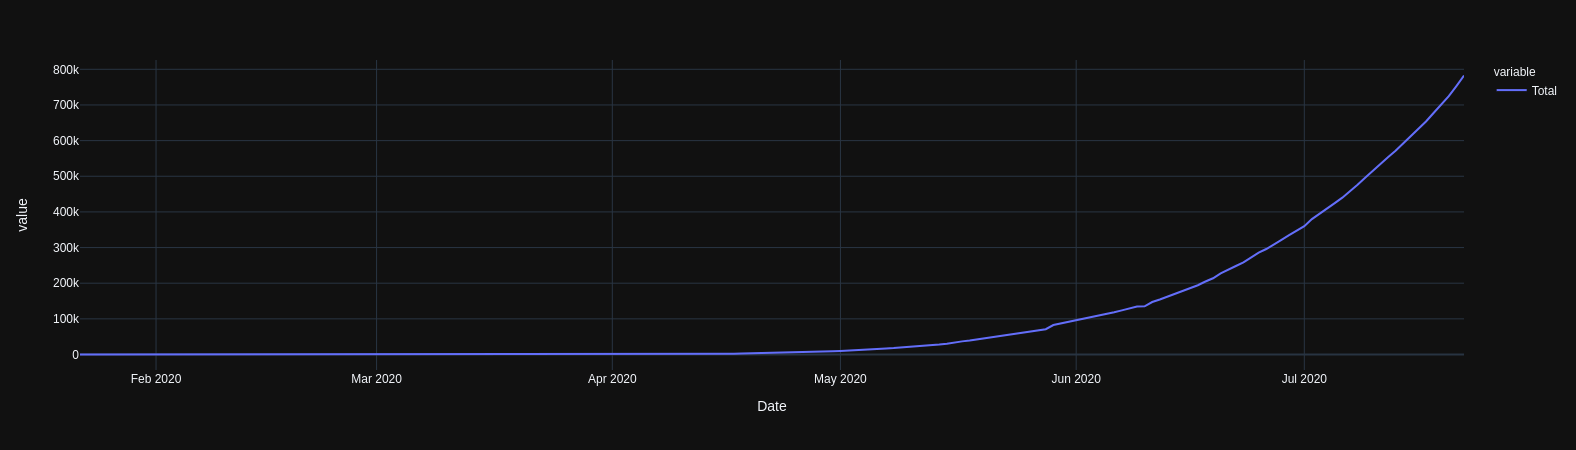

In [4]:
# Plotting the Data
px.line(data, template = 'plotly_dark')

In [5]:
# Setting a Split date for test and train datasets
split_date = pd.Timestamp('2020-05-17')
# Making sure no zeroes exist in dataframe
data = data[(data != 0).all(1)]

In [6]:
stepwise_model = auto_arima(data, start_p = 1, start_q = 1,
                           max_p = 3, max_q = 3, m = 12,
                           start_P = 0, seasonal = True,
                           d = 1, D = 1, trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True)
# Finding the pest p,d,q parametes for the model
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=2597.460, BIC=2612.344, Time=3.117 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=2720.676, BIC=2726.630, Time=0.047 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=2663.806, BIC=2675.713, Time=1.956 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=2711.377, BIC=2723.284, Time=0.663 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=2769.864, BIC=2772.841, Time=0.077 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=2628.344, BIC=2640.251, Time=0.645 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=2590.583, BIC=2608.444, Time=5.098 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=2589.916, BIC=2604.800, Time=3.386 seconds
Fit ARIMA(1,1,1)x(2,1,0,12) [intercept=True]; AIC=2592.729, BIC=2610.590, Time=8.092 seconds
Fit ARIMA(1,1,1)x(2,1,1,12) [intercept=True]; AIC=2598.204, BIC=2619.041, Time=14.658 seconds
Near non-invertible roots

In [7]:
# Splitting into test and train dataset
train = data.loc[:split_date]
test = data.loc[split_date:]
print('Test shape:',test.shape)
print('Train shape:',train.shape)
print(f'Min date from train set: {train.index.min().date()}')
print(f'Max date from train set:{train.index.max().date()}')
print(f'Min date from test set: {test.index.min().date()}')
print(f'Max date from test set: {test.index.max().date()}')

Test shape: (67, 1)
Train shape: (92, 1)
Min date from train set: 2020-02-16
Max date from train set:2020-05-17
Min date from test set: 2020-05-17
Max date from test set: 2020-07-22


In [8]:
# Fitting the model with train dataset
stepwise_model.fit(train)

# Forecasting
future_forecast = stepwise_model.predict(n_periods=len(test))

# This returns an array of predictions:
print(future_forecast)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])


[ 39768.19125583  43031.7718635   45861.92155028  49056.42632546
  52655.67758554  56120.65772979  60008.90260675  63932.52374403
  67416.02079163  71833.07205429  78234.51308273  82869.84271141
  88047.68514433  93490.97697395  98577.86501137 104035.66343447
 109870.30466406 115620.66413884 121773.59021163 128022.72889952
 133874.95658948 140607.8436961  149235.06378282 156274.82039146
 163833.19561207 171698.57364316 179208.71898981 187118.85410392
 195448.5575934  203705.8565784  212405.59309485 221209.12272638
 229630.30063918 238984.75811029 250300.88535762 259990.47090621
 270239.80860515 280811.36307033 291058.89079664 301726.56126723
 312828.5483021  323885.09528853 335399.95746932 347047.2778126
 358338.14717467 370573.12315801 384774.76725804 397397.01076958
 410594.38094624 424139.60675535 437380.11090124 451064.43962818
 465208.90668146 479328.91694848 493932.61582856 508689.08161169
 523110.49937715 538503.39579932 555892.64018876 571715.47361766
 588139.00326993 604931.89

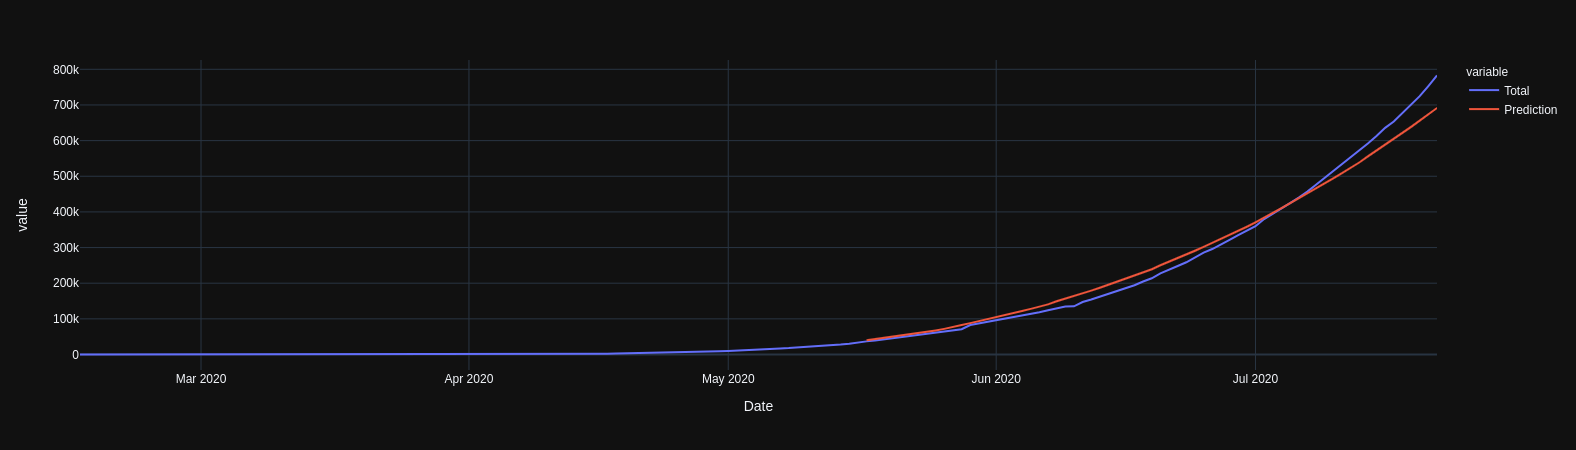

In [9]:
# Plotting the predicted values and actual values
px.line(pd.concat([data,future_forecast],axis=1), template = 'plotly_dark')

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
mean_absolute_percentage_error(test,future_forecast)

8.81772628296037

In [12]:
future_forecast['Actual']=test.Total
future_forecast

,Prediction,Actual
Date,,
2020-05-17,39768.191256,36795
2020-05-18,43031.771864,39233
2020-05-19,45861.921550,42309
2020-05-20,49056.426325,45422
2020-05-21,52655.677586,48553
...,...,...
2020-07-18,621444.072225,677423
2020-07-19,638422.354475,700087
2020-07-20,655882.205129,724578
